# 1.5 「ファインチューニング」で精度向上を実現する方法

- 本ファイルでは、学習済みのVGGモデルを使用し、ファインチューニングでアリとハチの画像を分類するモデルを学習します



# 学習目標

1.	PyTorchでGPUを使用する実装コードを書けるようになる
2.	最適化手法の設定において、層ごとに異なる学習率を設定したファインチューニングを実装できるようになる
3.	学習したネットワークを保存・ロードできるようになる



# 事前準備

- 1.4節で解説したAWS EC2 のGPUインスタンスを使用します


In [1]:
# パッケージのimport
import random
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

In [2]:
print(torch.__version__, torch.cuda.is_available())

2.0.0+cu117 True


In [3]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [4]:
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

batch_size = 32

In [5]:
OUTPUT_FEATURES = 2

MODEL_CATEGORY = 'ResNet'

OPTIMIZER_TYPE = 'Adam'
LEARNING_RATIO = 0.001
MOMENTUM = 0.0
WEIGHT_DECAY = 1e-6

NUM_EPOCHS = 30

# MLflow

In [6]:
import mlflow

In [7]:
# experimentの作成(読み込み)
experiment_id = mlflow.set_experiment(MODEL_CATEGORY)  # experimentの設定. 無ければ新規に作成.
print(experiment_id.experiment_id)

978472247857902971


# DatasetとDataLoaderを作成

In [8]:
# 1.3節で作成したクラスを同じフォルダにあるmake_dataset_dataloader.pyに記載して使用
from utils.dataloader_image_classification import (
    HymenopteraDataset,
    ImageTransform,
    make_datapath_list,
)

# アリとハチの画像へのファイルパスのリストを作成する
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

# Datasetを作成する
train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase="train"
)

val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase="val"
)


# DataLoaderを作成する
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

# 辞書オブジェクトにまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


# モデルを学習させる関数を作成

In [9]:
def plot_history(name, history):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
    axes[0].plot(
        range(len(history["train"]["loss"])),
        history["train"]["loss"],
        "r-o",
        label=f"{name}-train",
    )
    axes[0].plot(
        range(len(history["val"]["loss"])),
        history["val"]["loss"],
        "b--s",
        label=f"{name}-val",
    )
    axes[0].set_xlabel("Epochs", size=14)
    axes[0].set_ylabel("Loss", size=14)
    axes[0].tick_params(labelsize=12)
    axes[0].grid()
    axes[0].legend()

    axes[1].plot(
        range(len(history["train"]["acc"])),
        history["train"]["acc"],
        "r-o",
        label=f"{name}-train",
    )
    axes[1].plot(
        range(len(history["val"]["acc"])),
        history["val"]["acc"],
        "b--s",
        label=f"{name}-val",
    )
    axes[1].set_xlabel("Epochs", size=14)
    axes[1].set_ylabel("Accuracy", size=14)
    axes[1].tick_params(labelsize=12)
    axes[1].grid()
    axes[1].legend()
    plt.suptitle(f"{name}", size=16)
    # plt.show()
    return fig

In [10]:
def train_model(name, net, dataloaders_dict, criterion, optimizer, num_epochs):
    # 初期設定
    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # epochのループ
    history = {}
    history["train"] = {}
    history["val"] = {}
    history["train"]["loss"] = []
    history["train"]["acc"] = []
    history["val"]["loss"] = []
    history["val"]["acc"] = []

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch + 1, num_epochs))
        # print("-------------")

        # epochごとの訓練と検証のループ
        for phase in ["train", "val"]:
            if phase == "train":
                net.train()  # モデルを訓練モードに
            else:
                net.eval()  # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            # if (epoch == 0) and (phase == "train"):
            #     continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                # GPUが使えるならGPUにデータを送る
                inputs = inputs.to(device)
                labels = labels.to(device)

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == "train"):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測

                    # 訓練時はバックプロパゲーション
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                    # 結果の計算
                    epoch_loss += loss.item() * inputs.size(0)  # lossの合計を更新
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.cpu().double() / len(dataloaders_dict[phase].dataset)

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            history[phase]["loss"].append(epoch_loss)
            history[phase]["acc"].append(epoch_acc)

            # MLflow: track metrics
            mlflow.log_metric(f"{phase}_loss", epoch_loss, step=epoch)  # Train Loss
            mlflow.log_metric(f"{phase}_acc", epoch_acc, step=epoch)  # Train Loss

    return history

# 損失関数を定義

In [11]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

# ネットワークモデルの作成

In [25]:
def replace_last_layer_resnet(_net, output_features):
    last_in_features = _net.fc.in_features
    _net.fc = nn.Linear(in_features=last_in_features, out_features=output_features)
    return _net

def params_in_last_layers(_net):
    params_to_update = []
    for param in _net.classifier[-1].parameters():
        param.requires_grad = True
        params_to_update.append(param)
    return params_to_update

In [12]:
resnet_models = {
    "resnet18": {
        "model": models.resnet18,
        "weights": models.ResNet18_Weights.DEFAULT,
        "layers": 18,
    },
    "resnet34": {
        "model": models.resnet34,
        "weights": models.ResNet34_Weights.DEFAULT,
        "layers": 34,
    },
    "resnet50": {
        "model": models.resnet50,
        "weights": models.ResNet50_Weights.DEFAULT,
        "layers": 50,
    },
    "resnet101": {
        "model": models.resnet101,
        "weights": models.ResNet101_Weights.DEFAULT,
        "layers": 101,
    },
    "resnet152": {
        "model": models.resnet152,
        "weights": models.ResNet152_Weights.DEFAULT,
        "layers": 152,
    },
}

In [17]:
mlflow.end_run()

In [18]:
resnet_results = {}
for name, model_dict in resnet_models.items():
    model = model_dict["model"]
    weights = model_dict["weights"]

    # MLflow: runの作成
    now = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_name = f"{name}_{OPTIMIZER_TYPE}_LR{LEARNING_RATIO}_EPOCH{NUM_EPOCHS}_{now}"
    mlflow_run = mlflow.start_run(
        experiment_id=experiment_id.experiment_id,  # set_experimentの返り値を入れる.
        run_name=run_name,  # run_nameに、作成時刻を用いるようにした.
    )

    # MLflow: track params
    mlflow.log_params(
        {
            "Model": name,
            "Layers": model_dict["layers"],
            "Learning_ratio": LEARNING_RATIO,  # Learning ratio
            "Num_epochs": NUM_EPOCHS,  # num of Epochs
            "Optimizer": OPTIMIZER_TYPE,  # optimizer
        }
    )

    _net = model(weights=weights)
    _net = replace_last_layer_resnet(_net, OUTPUT_FEATURES)
    _net.train()
    print("Model:", name, last_in_features)

    # 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
    for param in _net.parameters():
        param.requires_grad = False

    params_to_update = params_in_last_layers(_net)

    if OPTIMIZER_TYPE=='SGD':
        optimizer = optim.SGD(
            params_to_update,
            lr=LEARNING_RATIO,
            momentum=MOMENTUM,
        )
        mlflow.log_params(
            {
                "Momentum": MOMENTUM,
            }
        )
    elif OPTIMIZER_TYPE=='Adam':
        optimizer = optim.Adam(
            params_to_update,
            lr=LEARNING_RATIO,
            weight_decay=WEIGHT_DECAY,
        )
        mlflow.log_params(
            {
                "Weight_decay": WEIGHT_DECAY,
            }
        )

    history = train_model(
        name, _net, dataloaders_dict, criterion, optimizer, num_epochs=NUM_EPOCHS
    )
    resnet_results[name] = history

    # # MLflow: track figure
    # figure = plot_history(name, history)
    # mlflow.log_figure(figure, "history.png")

    # MLflowL end run
    mlflow.end_run()

Model: resnet18 512
使用デバイス： cuda:0
Epoch 1/30


100%|██████████| 8/8 [00:03<00:00,  2.55it/s]


train Loss: 0.7300 Acc: 0.5473


100%|██████████| 5/5 [00:02<00:00,  2.47it/s]


val Loss: 0.6059 Acc: 0.6471
Epoch 2/30


100%|██████████| 8/8 [00:03<00:00,  2.50it/s]


train Loss: 0.5405 Acc: 0.7037


100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


val Loss: 0.4744 Acc: 0.8235
Epoch 3/30


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


train Loss: 0.4130 Acc: 0.8765


100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


val Loss: 0.3882 Acc: 0.9020
Epoch 4/30


100%|██████████| 8/8 [00:03<00:00,  2.49it/s]


train Loss: 0.3609 Acc: 0.8971


100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


val Loss: 0.3195 Acc: 0.9281
Epoch 5/30


100%|██████████| 8/8 [00:02<00:00,  2.67it/s]


train Loss: 0.2922 Acc: 0.9177


100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


val Loss: 0.2804 Acc: 0.9412
Epoch 6/30


100%|██████████| 8/8 [00:03<00:00,  2.44it/s]


train Loss: 0.2595 Acc: 0.9342


100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


val Loss: 0.2614 Acc: 0.9477
Epoch 7/30


100%|██████████| 8/8 [00:03<00:00,  2.52it/s]


train Loss: 0.2508 Acc: 0.9342


100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


val Loss: 0.2359 Acc: 0.9542
Epoch 8/30


100%|██████████| 8/8 [00:03<00:00,  2.45it/s]


train Loss: 0.2211 Acc: 0.9424


100%|██████████| 5/5 [00:01<00:00,  2.78it/s]


val Loss: 0.2270 Acc: 0.9477
Epoch 9/30


100%|██████████| 8/8 [00:03<00:00,  2.49it/s]


train Loss: 0.2029 Acc: 0.9465


100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


val Loss: 0.2114 Acc: 0.9477
Epoch 10/30


100%|██████████| 8/8 [00:03<00:00,  2.53it/s]


train Loss: 0.1720 Acc: 0.9753


100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


val Loss: 0.2029 Acc: 0.9477
Epoch 11/30


100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


train Loss: 0.1952 Acc: 0.9342


100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


val Loss: 0.2072 Acc: 0.9477
Epoch 12/30


100%|██████████| 8/8 [00:03<00:00,  2.52it/s]


train Loss: 0.1658 Acc: 0.9712


100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


val Loss: 0.1888 Acc: 0.9542
Epoch 13/30


100%|██████████| 8/8 [00:02<00:00,  2.77it/s]


train Loss: 0.1877 Acc: 0.9424


100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


val Loss: 0.1847 Acc: 0.9477
Epoch 14/30


100%|██████████| 8/8 [00:03<00:00,  2.53it/s]


train Loss: 0.1618 Acc: 0.9588


100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


val Loss: 0.1862 Acc: 0.9477
Epoch 15/30


100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


train Loss: 0.1663 Acc: 0.9342


100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


val Loss: 0.1763 Acc: 0.9542
Epoch 16/30


100%|██████████| 8/8 [00:03<00:00,  2.51it/s]


train Loss: 0.1507 Acc: 0.9753


100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


val Loss: 0.1738 Acc: 0.9477
Epoch 17/30


100%|██████████| 8/8 [00:03<00:00,  2.60it/s]


train Loss: 0.1239 Acc: 0.9753


100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


val Loss: 0.1682 Acc: 0.9608
Epoch 18/30


100%|██████████| 8/8 [00:03<00:00,  2.47it/s]


train Loss: 0.1365 Acc: 0.9753


100%|██████████| 5/5 [00:02<00:00,  2.43it/s]


val Loss: 0.1723 Acc: 0.9477
Epoch 19/30


100%|██████████| 8/8 [00:03<00:00,  2.60it/s]


train Loss: 0.1222 Acc: 0.9753


100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


val Loss: 0.1723 Acc: 0.9477
Epoch 20/30


100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


train Loss: 0.1306 Acc: 0.9547


100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


val Loss: 0.1647 Acc: 0.9542
Epoch 21/30


100%|██████████| 8/8 [00:03<00:00,  2.66it/s]


train Loss: 0.1014 Acc: 0.9794


100%|██████████| 5/5 [00:02<00:00,  2.47it/s]


val Loss: 0.1620 Acc: 0.9542
Epoch 22/30


100%|██████████| 8/8 [00:03<00:00,  2.66it/s]


train Loss: 0.1242 Acc: 0.9753


100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


val Loss: 0.1615 Acc: 0.9477
Epoch 23/30


100%|██████████| 8/8 [00:03<00:00,  2.45it/s]


train Loss: 0.1273 Acc: 0.9506


100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


val Loss: 0.1616 Acc: 0.9477
Epoch 24/30


100%|██████████| 8/8 [00:03<00:00,  2.52it/s]


train Loss: 0.1100 Acc: 0.9712


100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


val Loss: 0.1564 Acc: 0.9542
Epoch 25/30


100%|██████████| 8/8 [00:02<00:00,  2.67it/s]


train Loss: 0.1239 Acc: 0.9630


100%|██████████| 5/5 [00:02<00:00,  2.43it/s]


val Loss: 0.1579 Acc: 0.9542
Epoch 26/30


100%|██████████| 8/8 [00:03<00:00,  2.55it/s]


train Loss: 0.1202 Acc: 0.9630


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


val Loss: 0.1561 Acc: 0.9542
Epoch 27/30


100%|██████████| 8/8 [00:03<00:00,  2.45it/s]


train Loss: 0.1304 Acc: 0.9547


100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


val Loss: 0.1512 Acc: 0.9542
Epoch 28/30


100%|██████████| 8/8 [00:03<00:00,  2.47it/s]


train Loss: 0.1197 Acc: 0.9753


100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


val Loss: 0.1789 Acc: 0.9346
Epoch 29/30


100%|██████████| 8/8 [00:03<00:00,  2.58it/s]


train Loss: 0.1251 Acc: 0.9506


100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


val Loss: 0.1532 Acc: 0.9542
Epoch 30/30


100%|██████████| 8/8 [00:03<00:00,  2.45it/s]


train Loss: 0.1011 Acc: 0.9794


100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


val Loss: 0.1574 Acc: 0.9412
Model: resnet34 512
使用デバイス： cuda:0
Epoch 1/30


100%|██████████| 8/8 [00:03<00:00,  2.05it/s]


train Loss: 0.5762 Acc: 0.7325


100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


val Loss: 0.4110 Acc: 0.9085
Epoch 2/30


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


train Loss: 0.3937 Acc: 0.8765


100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


val Loss: 0.3028 Acc: 0.9085
Epoch 3/30


100%|██████████| 8/8 [00:03<00:00,  2.05it/s]


train Loss: 0.2839 Acc: 0.9424


100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


val Loss: 0.2548 Acc: 0.9477
Epoch 4/30


100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


train Loss: 0.2685 Acc: 0.9342


100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


val Loss: 0.2151 Acc: 0.9412
Epoch 5/30


100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


train Loss: 0.2271 Acc: 0.9383


100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


val Loss: 0.1956 Acc: 0.9412
Epoch 6/30


100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


train Loss: 0.1750 Acc: 0.9753


100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


val Loss: 0.1939 Acc: 0.9412
Epoch 7/30


100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


train Loss: 0.1976 Acc: 0.9424


100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


val Loss: 0.1716 Acc: 0.9542
Epoch 8/30


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


train Loss: 0.1555 Acc: 0.9588


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


val Loss: 0.1671 Acc: 0.9346
Epoch 9/30


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


train Loss: 0.1463 Acc: 0.9712


100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


val Loss: 0.1591 Acc: 0.9477
Epoch 10/30


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


train Loss: 0.1219 Acc: 0.9794


100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


val Loss: 0.1523 Acc: 0.9477
Epoch 11/30


100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


train Loss: 0.1162 Acc: 0.9794


100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


val Loss: 0.1483 Acc: 0.9477
Epoch 12/30


100%|██████████| 8/8 [00:03<00:00,  2.50it/s]


train Loss: 0.1322 Acc: 0.9753


100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


val Loss: 0.1537 Acc: 0.9477
Epoch 13/30


100%|██████████| 8/8 [00:03<00:00,  2.07it/s]


train Loss: 0.1293 Acc: 0.9671


100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


val Loss: 0.1414 Acc: 0.9673
Epoch 14/30


100%|██████████| 8/8 [00:03<00:00,  2.06it/s]


train Loss: 0.1505 Acc: 0.9465


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


val Loss: 0.1560 Acc: 0.9216
Epoch 15/30


100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


train Loss: 0.1079 Acc: 0.9712


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


val Loss: 0.1356 Acc: 0.9739
Epoch 16/30


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


train Loss: 0.1047 Acc: 0.9753


100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


val Loss: 0.1421 Acc: 0.9477
Epoch 17/30


100%|██████████| 8/8 [00:03<00:00,  2.36it/s]


train Loss: 0.1098 Acc: 0.9753


100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


val Loss: 0.1368 Acc: 0.9477
Epoch 18/30


100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


train Loss: 0.1000 Acc: 0.9671


100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


val Loss: 0.1333 Acc: 0.9477
Epoch 19/30


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


train Loss: 0.1010 Acc: 0.9794


100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


val Loss: 0.1234 Acc: 0.9542
Epoch 20/30


100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


train Loss: 0.0828 Acc: 0.9877


100%|██████████| 5/5 [00:02<00:00,  2.23it/s]


val Loss: 0.1230 Acc: 0.9542
Epoch 21/30


100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


train Loss: 0.0984 Acc: 0.9630


100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


val Loss: 0.1345 Acc: 0.9477
Epoch 22/30


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


train Loss: 0.0857 Acc: 0.9918


100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


val Loss: 0.1219 Acc: 0.9608
Epoch 23/30


100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


train Loss: 0.0910 Acc: 0.9794


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


val Loss: 0.1184 Acc: 0.9608
Epoch 24/30


100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


train Loss: 0.0837 Acc: 0.9835


100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


val Loss: 0.1316 Acc: 0.9477
Epoch 25/30


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


train Loss: 0.0846 Acc: 0.9753


100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


val Loss: 0.1224 Acc: 0.9412
Epoch 26/30


100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


train Loss: 0.0850 Acc: 0.9753


100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


val Loss: 0.1190 Acc: 0.9542
Epoch 27/30


100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


train Loss: 0.0764 Acc: 0.9877


100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


val Loss: 0.1208 Acc: 0.9412
Epoch 28/30


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


train Loss: 0.1124 Acc: 0.9630


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


val Loss: 0.1364 Acc: 0.9412
Epoch 29/30


100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


train Loss: 0.0659 Acc: 0.9877


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


val Loss: 0.1129 Acc: 0.9608
Epoch 30/30


100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


train Loss: 0.1022 Acc: 0.9547


100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


val Loss: 0.1267 Acc: 0.9412
Model: resnet50 2048
使用デバイス： cuda:0
Epoch 1/30


100%|██████████| 8/8 [00:19<00:00,  2.46s/it]


train Loss: 0.6220 Acc: 0.7119


100%|██████████| 5/5 [00:10<00:00,  2.05s/it]


val Loss: 0.5082 Acc: 0.9608
Epoch 2/30


100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


train Loss: 0.4300 Acc: 0.9547


100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


val Loss: 0.3661 Acc: 0.9477
Epoch 3/30


100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


train Loss: 0.3159 Acc: 0.9588


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


val Loss: 0.2870 Acc: 0.9542
Epoch 4/30


100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


train Loss: 0.2715 Acc: 0.9424


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


val Loss: 0.2482 Acc: 0.9477
Epoch 5/30


100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


train Loss: 0.2192 Acc: 0.9547


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


val Loss: 0.2237 Acc: 0.9477
Epoch 6/30


100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


train Loss: 0.2046 Acc: 0.9424


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


val Loss: 0.2063 Acc: 0.9542
Epoch 7/30


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


train Loss: 0.1768 Acc: 0.9630


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


val Loss: 0.1970 Acc: 0.9477
Epoch 8/30


100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


train Loss: 0.1625 Acc: 0.9712


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


val Loss: 0.1873 Acc: 0.9542
Epoch 9/30


100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


train Loss: 0.1334 Acc: 0.9794


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


val Loss: 0.1770 Acc: 0.9477
Epoch 10/30


100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


train Loss: 0.1257 Acc: 0.9794


100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


val Loss: 0.1724 Acc: 0.9477
Epoch 11/30


100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


train Loss: 0.1271 Acc: 0.9794


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


val Loss: 0.1662 Acc: 0.9608
Epoch 12/30


100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


train Loss: 0.1254 Acc: 0.9671


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


val Loss: 0.1650 Acc: 0.9608
Epoch 13/30


100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


train Loss: 0.1134 Acc: 0.9877


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


val Loss: 0.1593 Acc: 0.9608
Epoch 14/30


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


train Loss: 0.0960 Acc: 0.9959


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


val Loss: 0.1542 Acc: 0.9542
Epoch 15/30


100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


train Loss: 0.0911 Acc: 0.9918


100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


val Loss: 0.1499 Acc: 0.9542
Epoch 16/30


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


train Loss: 0.0920 Acc: 0.9959


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


val Loss: 0.1488 Acc: 0.9542
Epoch 17/30


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


train Loss: 0.1046 Acc: 0.9794


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


val Loss: 0.1451 Acc: 0.9608
Epoch 18/30


100%|██████████| 8/8 [00:05<00:00,  1.54it/s]


train Loss: 0.0841 Acc: 0.9959


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


val Loss: 0.1459 Acc: 0.9608
Epoch 19/30


100%|██████████| 8/8 [00:04<00:00,  1.62it/s]


train Loss: 0.0700 Acc: 0.9959


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


val Loss: 0.1432 Acc: 0.9608
Epoch 20/30


100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


train Loss: 0.0714 Acc: 0.9918


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


val Loss: 0.1401 Acc: 0.9542
Epoch 21/30


100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


train Loss: 0.0699 Acc: 0.9959


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


val Loss: 0.1386 Acc: 0.9608
Epoch 22/30


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


train Loss: 0.0726 Acc: 0.9918


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


val Loss: 0.1358 Acc: 0.9542
Epoch 23/30


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


train Loss: 0.0640 Acc: 0.9918


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


val Loss: 0.1343 Acc: 0.9542
Epoch 24/30


100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


train Loss: 0.0565 Acc: 0.9959


100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


val Loss: 0.1350 Acc: 0.9542
Epoch 25/30


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


train Loss: 0.0568 Acc: 0.9959


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


val Loss: 0.1357 Acc: 0.9542
Epoch 26/30


100%|██████████| 8/8 [00:04<00:00,  1.62it/s]


train Loss: 0.0587 Acc: 0.9877


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


val Loss: 0.1323 Acc: 0.9542
Epoch 27/30


100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


train Loss: 0.0707 Acc: 0.9918


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


val Loss: 0.1295 Acc: 0.9542
Epoch 28/30


100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


train Loss: 0.0471 Acc: 1.0000


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


val Loss: 0.1300 Acc: 0.9542
Epoch 29/30


100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


train Loss: 0.0683 Acc: 0.9835


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


val Loss: 0.1284 Acc: 0.9542
Epoch 30/30


100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


train Loss: 0.0540 Acc: 0.9959


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


val Loss: 0.1274 Acc: 0.9542
Model: resnet101 2048
使用デバイス： cuda:0
Epoch 1/30


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


train Loss: 0.6441 Acc: 0.6049


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


val Loss: 0.5412 Acc: 0.8758
Epoch 2/30


100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


train Loss: 0.4443 Acc: 0.8519


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


val Loss: 0.3788 Acc: 0.9542
Epoch 3/30


100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


train Loss: 0.3167 Acc: 0.9218


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


val Loss: 0.3068 Acc: 0.9412
Epoch 4/30


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


train Loss: 0.2600 Acc: 0.9588


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


val Loss: 0.2626 Acc: 0.9412
Epoch 5/30


100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


train Loss: 0.2273 Acc: 0.9424


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


val Loss: 0.2370 Acc: 0.9346
Epoch 6/30


100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


train Loss: 0.2044 Acc: 0.9588


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


val Loss: 0.2174 Acc: 0.9412
Epoch 7/30


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


train Loss: 0.1596 Acc: 0.9712


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


val Loss: 0.2031 Acc: 0.9412
Epoch 8/30


100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


train Loss: 0.1485 Acc: 0.9712


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


val Loss: 0.1964 Acc: 0.9412
Epoch 9/30


100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


train Loss: 0.1554 Acc: 0.9671


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


val Loss: 0.1917 Acc: 0.9412
Epoch 10/30


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


train Loss: 0.1229 Acc: 0.9877


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


val Loss: 0.1802 Acc: 0.9412
Epoch 11/30


100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


train Loss: 0.1124 Acc: 0.9835


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


val Loss: 0.1747 Acc: 0.9477
Epoch 12/30


100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


train Loss: 0.1207 Acc: 0.9671


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


val Loss: 0.1700 Acc: 0.9542
Epoch 13/30


100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


train Loss: 0.1164 Acc: 0.9712


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


val Loss: 0.1670 Acc: 0.9477
Epoch 14/30


100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


train Loss: 0.0953 Acc: 0.9835


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


val Loss: 0.1664 Acc: 0.9477
Epoch 15/30


100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


train Loss: 0.0968 Acc: 0.9877


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


val Loss: 0.1597 Acc: 0.9477
Epoch 16/30


100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


train Loss: 0.0899 Acc: 0.9835


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


val Loss: 0.1604 Acc: 0.9412
Epoch 17/30


100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


train Loss: 0.0846 Acc: 0.9959


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


val Loss: 0.1544 Acc: 0.9477
Epoch 18/30


100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


train Loss: 0.0763 Acc: 0.9959


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


val Loss: 0.1491 Acc: 0.9477
Epoch 19/30


100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


train Loss: 0.0697 Acc: 1.0000


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


val Loss: 0.1512 Acc: 0.9477
Epoch 20/30


100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


train Loss: 0.0779 Acc: 0.9959


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


val Loss: 0.1446 Acc: 0.9477
Epoch 21/30


100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


train Loss: 0.0761 Acc: 0.9918


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


val Loss: 0.1427 Acc: 0.9542
Epoch 22/30


100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


train Loss: 0.0813 Acc: 0.9835


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


val Loss: 0.1435 Acc: 0.9542
Epoch 23/30


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


train Loss: 0.0638 Acc: 0.9959


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


val Loss: 0.1378 Acc: 0.9477
Epoch 24/30


100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


train Loss: 0.0683 Acc: 0.9877


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


val Loss: 0.1407 Acc: 0.9542
Epoch 25/30


100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


train Loss: 0.0622 Acc: 0.9918


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


val Loss: 0.1412 Acc: 0.9542
Epoch 26/30


100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


train Loss: 0.0528 Acc: 0.9959


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


val Loss: 0.1452 Acc: 0.9542
Epoch 27/30


100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


train Loss: 0.0467 Acc: 1.0000


100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


val Loss: 0.1367 Acc: 0.9542
Epoch 28/30


100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


train Loss: 0.0494 Acc: 0.9959


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


val Loss: 0.1331 Acc: 0.9542
Epoch 29/30


100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


train Loss: 0.0567 Acc: 0.9959


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


val Loss: 0.1329 Acc: 0.9542
Epoch 30/30


100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


train Loss: 0.0559 Acc: 0.9877


100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


val Loss: 0.1368 Acc: 0.9542
Model: resnet152 2048
使用デバイス： cuda:0
Epoch 1/30


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


train Loss: 0.6198 Acc: 0.6955


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


val Loss: 0.5307 Acc: 0.9216
Epoch 2/30


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


train Loss: 0.4348 Acc: 0.9177


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


val Loss: 0.3986 Acc: 0.9412
Epoch 3/30


100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


train Loss: 0.3334 Acc: 0.9136


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


val Loss: 0.3289 Acc: 0.9412
Epoch 4/30


100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


train Loss: 0.2707 Acc: 0.9547


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


val Loss: 0.2850 Acc: 0.9346
Epoch 5/30


100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


train Loss: 0.2488 Acc: 0.9342


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


val Loss: 0.2477 Acc: 0.9542
Epoch 6/30


100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


train Loss: 0.2213 Acc: 0.9424


100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


val Loss: 0.2411 Acc: 0.9281
Epoch 7/30


100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


train Loss: 0.1826 Acc: 0.9753


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


val Loss: 0.2198 Acc: 0.9412
Epoch 8/30


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


train Loss: 0.1632 Acc: 0.9794


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


val Loss: 0.2048 Acc: 0.9542
Epoch 9/30


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


train Loss: 0.1486 Acc: 0.9712


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


val Loss: 0.1996 Acc: 0.9542
Epoch 10/30


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


train Loss: 0.1226 Acc: 0.9877


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


val Loss: 0.1898 Acc: 0.9608
Epoch 11/30


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


train Loss: 0.1209 Acc: 0.9794


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


val Loss: 0.1845 Acc: 0.9477
Epoch 12/30


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


train Loss: 0.1075 Acc: 0.9918


100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


val Loss: 0.1790 Acc: 0.9477
Epoch 13/30


100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


train Loss: 0.1131 Acc: 0.9794


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


val Loss: 0.1691 Acc: 0.9608
Epoch 14/30


100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


train Loss: 0.1244 Acc: 0.9712


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


val Loss: 0.1644 Acc: 0.9608
Epoch 15/30


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


train Loss: 0.1131 Acc: 0.9794


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


val Loss: 0.1589 Acc: 0.9608
Epoch 16/30


100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


train Loss: 0.0967 Acc: 0.9835


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


val Loss: 0.1578 Acc: 0.9608
Epoch 17/30


100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


train Loss: 0.1034 Acc: 0.9835


100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


val Loss: 0.1560 Acc: 0.9542
Epoch 18/30


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


train Loss: 0.0836 Acc: 0.9835


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


val Loss: 0.1652 Acc: 0.9412
Epoch 19/30


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


train Loss: 0.0742 Acc: 0.9959


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


val Loss: 0.1547 Acc: 0.9542
Epoch 20/30


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


train Loss: 0.0887 Acc: 0.9918


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


val Loss: 0.1460 Acc: 0.9673
Epoch 21/30


100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


train Loss: 0.0746 Acc: 0.9877


100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


val Loss: 0.1442 Acc: 0.9608
Epoch 22/30


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


train Loss: 0.0733 Acc: 0.9959


100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


val Loss: 0.1439 Acc: 0.9542
Epoch 23/30


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


train Loss: 0.0961 Acc: 0.9877


100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


val Loss: 0.1413 Acc: 0.9608
Epoch 24/30


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


train Loss: 0.0856 Acc: 0.9835


100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


val Loss: 0.1392 Acc: 0.9608
Epoch 25/30


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


train Loss: 0.0751 Acc: 0.9918


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


val Loss: 0.1402 Acc: 0.9542
Epoch 26/30


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


train Loss: 0.0621 Acc: 0.9959


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


val Loss: 0.1343 Acc: 0.9542
Epoch 27/30


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


train Loss: 0.0594 Acc: 1.0000


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


val Loss: 0.1388 Acc: 0.9608
Epoch 28/30


100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


train Loss: 0.0622 Acc: 1.0000


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


val Loss: 0.1367 Acc: 0.9477
Epoch 29/30


100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


train Loss: 0.0648 Acc: 0.9835


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


val Loss: 0.1313 Acc: 0.9542
Epoch 30/30


100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


train Loss: 0.0625 Acc: 0.9918


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

val Loss: 0.1310 Acc: 0.9608


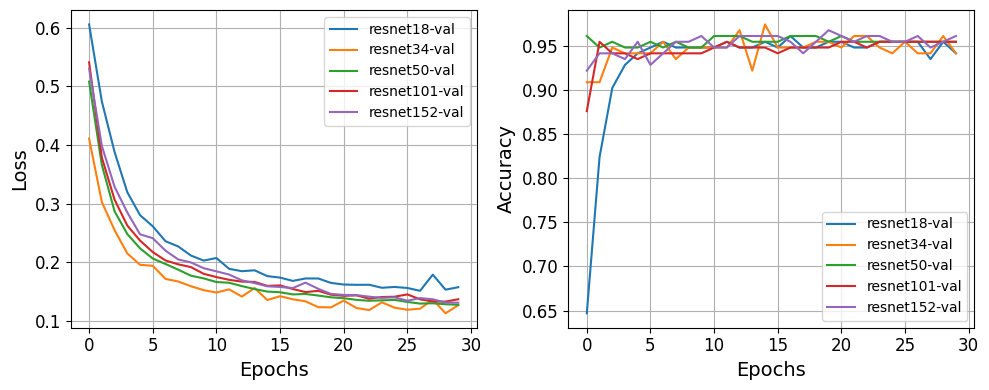

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
for model in resnet_results.keys():
    # for phase in resnet_results[model].keys():
    for phase in ["val"]:
        axes[0].plot(
            range(len(resnet_results[model][phase]["loss"])),
            resnet_results[model][phase]["loss"],
            # plot_style[phase],
            label=f"{model}-{phase}",
        )
axes[0].set_xlabel("Epochs", size=14)
axes[0].set_ylabel("Loss", size=14)
axes[0].tick_params(labelsize=12)
axes[0].grid()
axes[0].legend()

for model in resnet_results.keys():
    # for phase in resnet_results[model].keys():
    for phase in ["val"]:
        axes[1].plot(
            range(len(resnet_results[model][phase]["acc"])),
            resnet_results[model][phase]["acc"],
            # plot_style[phase],
            label=f"{model}-{phase}",
        )
axes[1].set_xlabel("Epochs", size=14)
axes[1].set_ylabel("Accuracy", size=14)
axes[1].tick_params(labelsize=12)
axes[1].grid()
axes[1].legend()
plt.show()

# 学習したネットワークを保存・ロード

In [ ]:
# # PyTorchのネットワークパラメータの保存
# save_path = "./weights_fine_tuning.pth"
# torch.save(net.state_dict(), save_path)

In [ ]:
# # PyTorchのネットワークパラメータのロード
# load_path = "./weights_fine_tuning.pth"
# load_weights = torch.load(load_path)
# net.load_state_dict(load_weights)

# # GPU上で保存された重みをCPU上でロードする場合
# load_weights = torch.load(load_path, map_location={"cuda:0": "cpu"})
# net.load_state_dict(load_weights)

以上